# Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

Nama: Kemal Adam Roisy

Email: kemal.adam@sci.ui.ac.id

Materi: Belajar Pengembangan Machine Learning


## Kriteria Submission:



1.   Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel.
2.   Harus menggunakan LSTM dalam arsitektur model.
3.   Validation set sebesar 20% dari total dataset.
4.   Model harus menggunakan model sequential.
5.   Harus menggunakan Learning Rate pada Optimizer.
6.   MAE < 10% skala data.



# Dataset

Data Source: IBM Stock Price (23-7-1991 to 23-7-2021

url: https://stooq.com/q/?s=ibm.us&c=30y&t=l&a=lg&b=0


In [1]:
import pandas as pd
import pandas_datareader as pdr

import datetime as dt

import matplotlib.pyplot as plt

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from math import ceil
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [2]:
start = dt.datetime(1991, 7, 23)
end = dt.datetime.today()
df = pdr.data.DataReader('IBM', 'stooq', start, end)

In [3]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-07-21,139.97,141.39,139.6500,141.30,4803977.0
2021-07-20,143.00,144.92,138.7000,139.97,13611675.0
2021-07-19,136.45,138.49,136.2089,137.92,8582302.0
2021-07-16,141.00,141.00,138.5900,138.90,4109308.0
2021-07-15,139.32,140.46,138.8005,140.45,3639698.0


In [4]:
df.drop(['Open','High','Low','Volume'],axis=1, inplace=True)
df.sort_values('Date', inplace=True)

In [5]:
df.isnull().sum()

Close    0
dtype: int64

In [6]:
df.describe()

,Close
count,7556.000000
mean,79.614133
std,43.843921
min,7.297400
25%,51.296500
50%,76.216000
75%,123.027500
max,159.520000


Total Dataset yang dapat digunakan 7556 (> 1000) memenuhi **kriteria 1**

In [7]:
scaler = MinMaxScaler()
normalized = scaler.fit_transform(np.array(df['Close']).reshape(-1,1))
df['Close'] = normalized

df.head()

,Close
Date,
1991-07-23,0.069737
1991-07-24,0.069862
1991-07-25,0.069599
1991-07-26,0.069599
1991-07-29,0.070624


Text(0.5, 1.0, 'IBM Close Price')

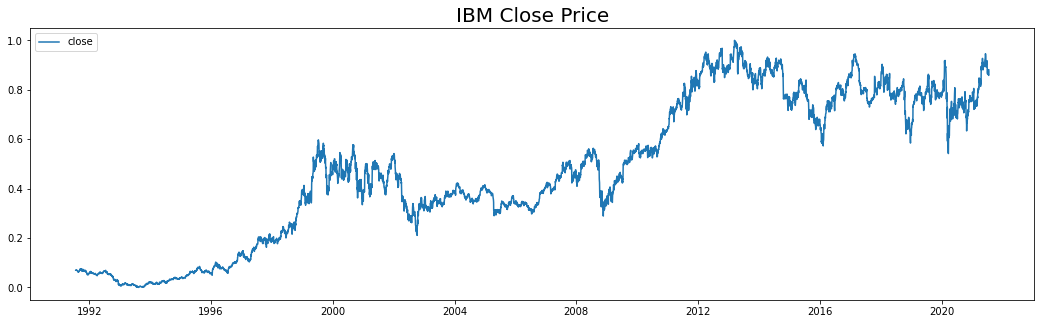

In [8]:
dates = df.index.values
close = df['Close'].values

plt.figure(figsize=(18,5))

plt.plot(dates, close, label='close')
plt.legend(loc='upper left')
plt.title('IBM Close Price',
          fontsize=20)

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

Validation set diatur menjadi 20% (test_size=0.2) sesuai **kriteria 3**

In [10]:
X_train, X_test = train_test_split(close, test_size=0.2, shuffle=False)

window_size = 64
batch_size = 200
shuffle_buffer_size = 1000

In [11]:
 data_train = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)
 data_test = windowed_dataset(X_test, window_size, batch_size, shuffle_buffer_size)

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<0.09 and logs.get('val_mae')<0.09):
      print("\nMean Absolute Error < 9% dari data yang sudah dinormalisasi!\n")
      print("mae = {}%".format(logs.get('mae')*100), "val_mae = {}%".format(logs.get('val_mae')*100))
      self.model.stop_training = True

callbacks = myCallback()

Pemodelan menggunakan 2 layer LSTM sesuai **keiteria 2** dan menggunakan model Sequential sesuai **kriteria 4**

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
])

Menetapkan nilai learning rate dan momentum pada optimizer sesuai **kriteria 5**

In [15]:
 optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(data_train, epochs=300,
                    validation_data=data_test,
                    batch_size=16,
                    callbacks=[callbacks],
                    verbose=2
                    )

Epoch 1/300
30/30 - 6s - loss: 0.1148 - mae: 0.3966 - val_loss: 0.2880 - val_mae: 0.7557
Epoch 2/300
30/30 - 1s - loss: 0.1050 - mae: 0.3740 - val_loss: 0.2669 - val_mae: 0.7273
Epoch 3/300
30/30 - 1s - loss: 0.0964 - mae: 0.3539 - val_loss: 0.2499 - val_mae: 0.7035
Epoch 4/300
30/30 - 1s - loss: 0.0892 - mae: 0.3374 - val_loss: 0.2350 - val_mae: 0.6820
Epoch 5/300
30/30 - 1s - loss: 0.0826 - mae: 0.3234 - val_loss: 0.2221 - val_mae: 0.6629
Epoch 6/300
30/30 - 1s - loss: 0.0772 - mae: 0.3126 - val_loss: 0.2104 - val_mae: 0.6451
Epoch 7/300
30/30 - 1s - loss: 0.0720 - mae: 0.3019 - val_loss: 0.1990 - val_mae: 0.6271
Epoch 8/300
30/30 - 1s - loss: 0.0676 - mae: 0.2925 - val_loss: 0.1881 - val_mae: 0.6095
Epoch 9/300
30/30 - 1s - loss: 0.0633 - mae: 0.2834 - val_loss: 0.1780 - val_mae: 0.5928
Epoch 10/300
30/30 - 1s - loss: 0.0593 - mae: 0.2740 - val_loss: 0.1683 - val_mae: 0.5762
Epoch 11/300
30/30 - 1s - loss: 0.0563 - mae: 0.2668 - val_loss: 0.1582 - val_mae: 0.5583
Epoch 12/300
30/30 

Nilai Mean Absolute Error :

training mae = 7.8% (<10%)

validation mae = 8.9% (<10%) 

sesuai **kriteria 6**

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

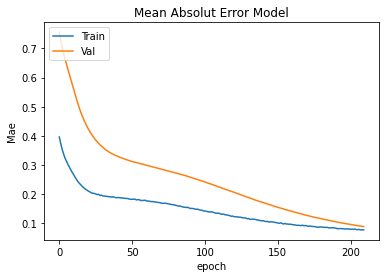

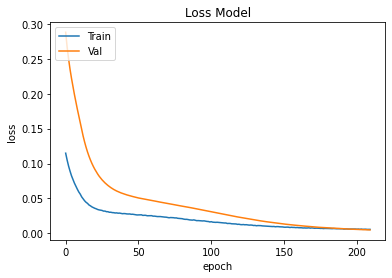

In [17]:
# Plot MAE
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolut Error Model')
plt.ylabel('Mae')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
print('\n\n')
# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()